# QuTiP Lecture: Photon Scattering in Quantum Optical Systems


Author: Ben Bartlett, Stanford University: [benbartlett@stanford.edu](mailto:benbartlett@stanford.edu) | [stanford.edu/people/benbartlett](https://stanford.edu/people/benbartlett) | [github:bencbartlett](https://github.com/bencbartlett/)

This Jupyter notebook demonstrates functionality for numerically computing photon scattering in arbitrary driven systems coupled to some configuration of output waveguides using [QuTiP: The Quantum Toolbox in Python](http://qutip.org/). This notebook closely follows the treatment of the problem given in K.A. Fischer, et.al. (2017), "Scattering of Coherent Pulses from Quantum-Optical Systems" (arXiv: [1710.02875](https://arxiv.org/abs/1710.02875)).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import * 
from multiprocessing import Pool, cpu_count
from IPython.display import display, Math, Latex

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

worker_count = max(cpu_count() - 1, 1)

## Introduction

$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
$$
In this section, we briefly review the generalized problem of photon scattering in quantum optical systems discussed in Fischer, et.al. (2017); see the publication for a more complete treatment of the problem. 

### Problem definition
Consider an arbitrary system with a Hamiltonian $H_S(t)$ coupled to a bath of waveguide modes:

<img src="images/system_waveguide_coupling.png", width=500>

The problem we address in this notebook is this: if we drive the system with some excitation field, such as a laser pulse, how do photons scatter from the system into the waveguide?

The system Hamiltonians we will consider take the form
\begin{equation}
H_\textrm{S}(t) =
\begin{cases}
H_\textrm{0S}+ H_\textrm{1S}(t) & \text{if } 0<t<T_P\\
H_\textrm{0S} & \text{otherwise},
\end{cases}
\end{equation}

where $T_P$ is the pulse duration (if well-defined). The waveguide Hamiltonians can be described as 

\begin{equation}
H_{0B} = \int_{-\infty}^\infty d\omega \omega b_\omega^\dagger b_\omega,
\end{equation}

which can be rewritten in a temporal basis (roughly speaking, indexed by emission time) by Fourier transforming the operators $b_\omega$:

\begin{equation}
b_\tau \equiv \int_{-\infty}^\infty \frac{d\omega}{\sqrt{2\pi}} e^{-i\omega \tau}b_\omega, \quad \ket{\vec{\tau}^{(m)}} \equiv b_{\tau_1}^\dagger \cdots b_{\tau_m}^\dagger \ket{0_B}
\end{equation}

The total Schrodinger-picture Hamiltonian can be written as a sum of system, bath, and coupling terms $H(t)=H_\textrm{S}(t) + V + H_{0\textrm{B}}$, and can be transformed into the interaction picture:

\begin{equation}
H_\textrm{I}(t)=H_\textrm{S}(t) + \textrm{e}^{i H_{0\textrm{B}} t}V\textrm{e}^{-i H_{0\textrm{B}} t}.
\end{equation}

To solve the dynamics of this system, we could integrate the Schrodinger equation:

\begin{equation}
\textrm{i}\frac{\partial}{\partial t}\left|\Psi_\textrm{I}(t)\right>=H_\textrm{I}(t)\left|\Psi_\textrm{I}(t)\right>.
\end{equation}

### Coarse-grained dynamics and the scattering operator
However, practically integrating this equation is not feasible, so we instead "coarse-grain" the temporal dynamics to $\Delta t$ and take a continuous limit as $\Delta t \rightarrow 0$. If we define an "effective Hamiltonian" $H_\text{eff}(t)=H_S(t)-i\frac{\gamma}{2}a^\dagger a$, we can generate an effective propagator mapping the system from the $k^\text{th}$ to the $k+1^\text{th}$ time bin which is correct up to $\mathscr{O}(\Delta t)$:

\begin{equation}
U_\text{eff}[k+1,k] \equiv \bra{0_k} U[k+1,k] \ket{0_k} \approx \exp\left[-i\int_{k\Delta t}^{(k+1)\Delta t} dt H_\text{eff}(t)\right].
\end{equation}

From this, we can derive the scattering operator for the system into the system of waveguides (see the paper for more detail). For scattering of $N$ photons into single waveguide, this operator $\left < \hat{\Omega}^\dagger_- \right > _{\vec{\tau}^{(m)}} $ takes the form:

$$ \left < \hat{\Omega}^\dagger_- \right > _{\vec{\tau}^{(m)}} = \left<0_S\right| U_\text{eff}(\tau_\text{max},\tau_m) \prod_{q=N}^1 \sqrt\gamma a U_\text{eff}(\tau_q, \tau_{q-1}) \left| \psi_S(0) \right>,$$

with $\tau_0 = 0$, $\tau_\text{max} = \max (T_p, \tau_m )$. The multi-waveguide case will be discussed later in the notebook.

### The temporal basis
For a system coupled to $W$ waveguides emitting $N$ photons approximated by coarse-grained dynamics with $T$ time bins, the temporal basis described in Fischer, et al. (Eq. 138 and 153, with slight notation changes) can be thought of as a system of $T$ qubits for each of the $W$ waveguides with a total of $N$ creation operators applied to $\ket{0}$:

\begin{equation}
\ket{\vec{\tau}_{(W)}^{(N)}} = \ket{\vec{\tau}_1^{(w_1)}, \vec{\tau}_2^{(w_2)}, \cdots ,\vec{\tau}_W^{(w_W)}} = \prod_{i=1}^N b_{w_i,\tau_{1}}^\dagger b_{w_i,\tau_{2}}^\dagger \cdots b_{i,\tau_{n_i}}^\dagger \ket{0},
\end{equation}

where $w_k$ denotes scattering into the $k$th waveguide and $n_i$ denotes the maximum number of photons scattered into some waveguide. Although this basis is exact, it has an intractable space complexity of $\mathscr{O}(2^{T\cdot M})$, making it insuitable for simulation work. 

The temporal basis we use in the `qutip.scattering` module is more closely modeled after ladder operators and explicitly restricts the basis to $N$ emissions. To generate the basis, we make $M$ copies of the $T$ time bins. Emission of a photon at the $i$th time bin into the $w$th waveguide is represented by an entry in the $(w T + i)$th index of a $(W T)$-dimensional vector, so the overall temporal basis is given by:

\begin{equation}
\ket{\vec{\tau}_{(W)}^{(N)}} = \ket{\vec{\tau}_1^{(w_1)}, \vec{\tau}_2^{(w_2)}, \cdots ,\vec{\tau}_W^{(w_W)}} = \bigotimes_{n=1}^N \ket{\tau_{n, w_n}} = \bigotimes_{n=1}^N \mathscr{\vec T}[w_n T + \tau_n],
\end{equation}

where $\tau_{n, w_n}$ denotes emission into the $w_n$th waveguide of the $n$th photon and $\mathscr{\vec T}[w_n T + \tau_n]$ denotes the basis vector corresponding to $\tau_{n, w_n}$, namely the $(w_n T+\tau_n)$-th index. The creation operators in the original temporal basis are mapped to $(w_i T + \tau_n)$ applications of the "temporal ladder operator": 

\begin{equation}
b_{w_i,\tau_n}^\dagger = \frac{(a^\dagger)^{w_i T + \tau_n}}{\sqrt{(w_i T + \tau_n)!}}
\end{equation}

This gives this basis a space complexity of $\mathscr{O}\left((W T)^N\right)$, which is more managable given that for most applicaitons $T\gg W,N$.

## Single waveguide: driven quantum two-level system

To demonstrate the `qutip.scattering` module, we'll start with the simplest case of a two-level quantum system coupled to a single output waveguide. The system has initial state $\left |{\psi_0} \right> = \left|e\right>_\text{sys} \otimes \left|vac\right>_\text{wg}$ with a bare Hamiltonian of $H_{0S} = \omega_0 \sigma^\dagger \sigma $. Adding an effective non-Hermitian term to govern the evolution of the system under spontaneous emission, $H_\text{eff} = H_{0S} - i \frac{\gamma}{2}\sigma^\dagger \sigma$. When the system is driven by a coherent pulse, it undergoes Rabi oscillations. Picking a square pulse to give a simple Hamiltonian, the overall effective Hamiltonian is $H_\text{eff}(t) = H_{0S} - H_{1S}(t)- i \frac{\gamma}{2}\sigma^\dagger \sigma$, where

$$H_{1S}(t) = \begin{cases} 
\Omega\left( i e^{-i \omega_0 t} \sigma^\dagger - i e^{i\omega_0 t} \sigma \right) & \text{ if } 0<t<T_P \\
0 & \text{ otherwise.} \\
\end{cases}$$

We define the Hamiltonian and choose pulse parameters below.

In [2]:
# Pulse parameters
w0    = 10 * 2 * np.pi               # arbitrary laser frequency
gamma = 1.0                          # arbitrary coupling constant

# Operators
sm   = np.sqrt(gamma) * destroy(2)   # TLS coupled collapse operator
psi0 = basis(2,0)                    # starting state |psi(0)> = |0>

def Htls(gamma, pulseLength, pulseArea):
    RabiFreq = pulseArea / (2*pulseLength)
    
    # Bare Hamiltonian for a TLS
    H0S = w0 * create(2) * destroy(2)  

    # Define H_1S(t)
    H1S1 = lambda t, args: RabiFreq * 1j*np.exp(-1j*w0*t) * (t < pulseLength) 
    H1S2 = lambda t, args: RabiFreq * -1j*np.exp(1j*w0*t) * (t < pulseLength)

    # Put the Hamiltonian in QuTiP list-callback form
    return [H0S - 1j/2 * sm.dag() * sm, 
            [sm.dag(), H1S1], 
            [sm, H1S2]]

### Computing photon scattering amplitudes

Let's begin by computing the scattering amplitude of a single-photon emission as a function of time. For this, we can use the `temporal_scattered_state()` function in the `scattering` module, which computes:

$$ 
\begin{align}
\left| \phi_n \right> & = \int_0^\infty d\tau_1 \int_{\tau_1}^\infty d\tau_2 \cdots \int_{\tau_{n-1}}^\infty d\tau_n \left<0_S, \{ \tau_1,\tau_2,\cdots,\tau_n \} \mid \psi(t\rightarrow \infty) \right> \left|\tau_1,\tau_2,\cdots,\tau_n\right> \\
& = \int_{\vec\tau_n} d\vec\tau_n \left<0_S, \{\vec\tau_n \} \mid \psi(t\rightarrow \infty) \right> \left|\vec\tau_n\right> \\
& = \int_{\vec\tau_n} d\vec\tau_n \left < \hat{\Omega}^\dagger_- \right > _{\vec{\tau}_n} \left|\vec\tau_n\right> \\
& = \hat{\Omega}^\dagger_- \ket{\psi_0}.
\end{align}
$$

This function takes as arguments the Hamiltonian or the effective Hamiltonian, the initial system state, the number of emissions, a list of collapse operators (one for each waveguide - see the following section for more detail), and a list of times. The list of times must exceed the duration of the pulse for the function to yield sensible results (or, if the pulse does not have a well-defined end, the times list must contain most of the temporal region of interest). 

By passing the keyword argument `construct_effective_hamiltonian`, you can tell the function whether the Hamiltonian you provided is $H$ or $H_\text{eff}$; by default, the value is `True`, so an effective Hamiltonian will be constructed from the provided list of collapse operators as $H_\text{eff} = H - \frac{i}{2} \sum_n \tt{\text{c_ops}}[n]$. The function iteratively calls `photon_scattering_operator()` and returns the temporal scattered state as a `Qobj`, so to extract the amplitudes $a_t$, we will need to project it onto the temporal basis:

$$a_t = \left< t \mid \phi_n \right> = \bra{t}\hat{\Omega}^\dagger_- \ket{\psi_0} = \bra{t}\int_{\vec\tau_n}d\vec\tau_n \left < \hat{\Omega}^\dagger_- \right > _{\vec{\tau}_n} \left|\vec\tau_n\right>,$$

which we can do usng the `temporal_basis_vector()` function. This function takes a nested list of temporal emission indices for each waveguide and the total number of time bins. For the single-waveguide case, the nested list of time indices simply reduces to `[[indexOf(t)]]`.

Computing the scattering amplitudes using the same parameters as the ones used in the analytical results of Figure 5(b) in Fischer, et al., we obtain visually identical results:

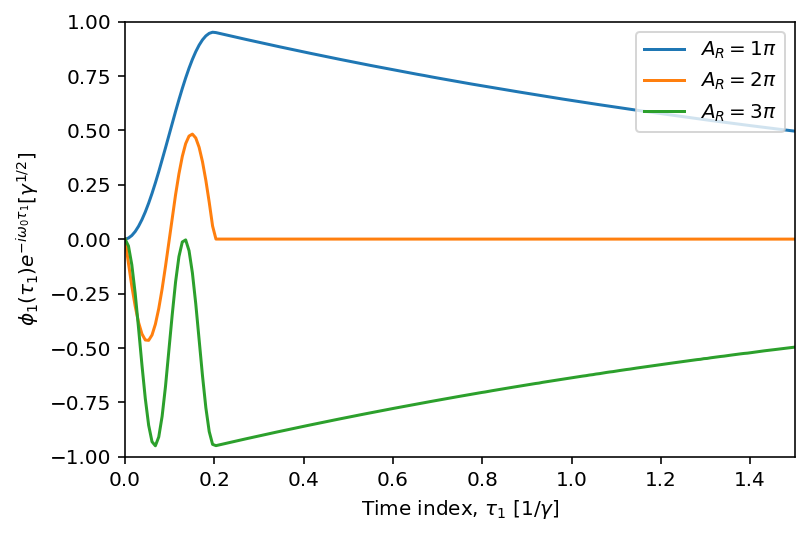

In [3]:
T = 200
tlist = np.linspace(0,1.5/gamma,T)
pulse_length = 0.2 / gamma
pulse_areas = [np.pi, 2*np.pi, 3*np.pi]

for pulse_area in pulse_areas:
    # Use construct_effective_hamiltonian=False since we are providing H_eff in this case
    scattered_state = temporal_scattered_state(Htls(gamma, pulse_length, pulse_area), psi0, 1, [sm], tlist, 
                                               construct_effective_hamiltonian = False)
    amplitudes = []
    for i in range(T):
        amplitudes.append((temporal_basis_vector([[i]], T).dag() * scattered_state).full().item())
    # Adjust amplitudes for time evolution
    amplitudes = np.real(np.array(amplitudes) * np.exp(1j * w0 * tlist))
    plt.plot(tlist, amplitudes, label = "$A_R = {}\pi$".format(round(pulse_area / np.pi)))
    
plt.ylim(-1,1)
plt.xlim(tlist[0],tlist[-1])
plt.xlabel('Time index, $\\tau_1$ [$1/\gamma$]')
plt.ylabel('$\phi_1 ( \\tau_1) e^{-i \omega_0 \\tau_1} [\gamma^{1/2}]$')
plt.legend(loc = 'upper right')
plt.show()

### Total photon scattering probability

To calculate the total probability of emitting a certain number of photons, $P_n = \left<\phi_n \mid \phi_n\right>$, we can expand in terms a complete set of temporal projection operators $\int_{\vec\tau_n} \left| \tau_n \right>\left<\tau_n \right| d \tau_n$:

$$\begin{align}
P_n & = \left<\phi_n \mid \phi_n\right> \\
& = \int_{\vec\tau_n} d\vec\tau_n \left<\phi_n \mid \vec\tau_n \right>\left<\vec\tau_n \mid \phi_n \right> \\
& = \int_0^\infty d\tau_1 \int_{\tau_1}^\infty d\tau_2 \cdots \int_{\tau_{n-1}}^\infty d\tau_n  \left<\phi_n \mid \tau_1, \tau_2, \cdots \tau_n \right>\left<\tau_1, \tau_2, \cdots \tau_n \mid \phi_n \right> \\
\end{align}$$

More simply, however, you can use the `scattering_probability()` function, which recursively integrates the results of `temporal_scattered_state()` to return the total probability of $N$ photons being scattered from the system over the specified list of times. Notably, the time list does not need to be linear - the integration routines will account for unevenly spaced time bins. This allows you to do things like provide logarithmically spaced times, which better captures regions closer to $t=0$ where more interesting dynamics occur.

To make things faster, we'll remove the time dependence of $H_\text{eff}$ with a rotating frame transformation. We'll also drop the $-\frac{i}{2} \sigma^\dagger \sigma$ term and the `construct_effective_hamiltonian = False` argument to allow `temporal_scattered_state()` to construct the effective Hamiltonian on its own. 

Since `scattering_probability()` returns a pickleable result (a number), it is also very easily multiprocessed, so we'll take this opportunity to show how this can be done. (Note that this does make debugging untested code a more opaque process.) Computing the total scattering probabilities for $N=0,1,2$ photons as a function of pulse area yields a similar result to Figure 5(a) in Fischer, et al:

In [4]:
def Htls_rft(gamma, pulseLength, pulseArea):
    RabiFreq = pulseArea / (2*pulseLength)
    return [[sm.dag() + sm, lambda t, args: RabiFreq * (t < pulseLength)]]

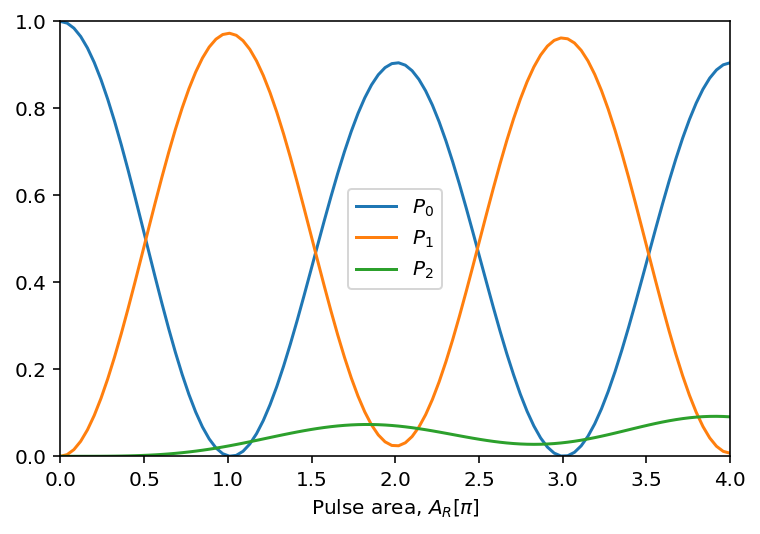

In [5]:
pulse_length = 0.2 / gamma
pulse_areas = np.linspace(0,4*np.pi,100)
tlist = np.geomspace(gamma, 7*gamma, 40) - gamma
emission_nums = [0,1,2]

def scattering_probability_multiprocess(pulse_area, n):
    # Helper function to allow pool.map parallelism
    return scattering_probability(Htls_rft(gamma, pulse_length, pulse_area), psi0, n, [sm], tlist)

pool = Pool(worker_count)
for n in emission_nums:
    args = [(pulse_area, n) for pulse_area in pulse_areas]
    scatter_probs = pool.starmap(scattering_probability_multiprocess, args)
    plt.plot(pulse_areas / np.pi, scatter_probs, label = "$P_{}$".format(n))
pool.close()

plt.ylim(0,1)
plt.xlim(pulse_areas[0]/np.pi, pulse_areas[-1]/np.pi)
plt.xlabel("Pulse area, $A_R [\\pi]$")
plt.legend()
plt.show()

### Computing second-order coherence in the scattered state

In experiments, the two-photon wavefunction is often characterized from the second-order coherence:

\begin{equation}
G^{(2)}(t_1,t_2) \approx \bra{\phi_2} b_0^\dagger(t_1) b_0^\dagger(t_2) b_0(t_2) b_0(t_1) \ket{\phi_2}.
\end{equation}

Since the creation operators $b_0^\dagger$ do not translate exactly into the temporal basis used in `qutip.scattering`, this is not directly computable in this form, but we can still calculate $G^{(2)}$ with creative application of `temporal_basis_vector()`. The second-order coherence measures the correlations for photons to be emitted at times $t_1$ and $t_2$ with corresponding time-bin indices `i` and `j`. To compute the coherence, we first compute the temporal scattered state, then project it onto `temporal_basis_vector([[i,j]], T)`, which gives the basis vector corresponding to photons emitted at time indices `i` and `j` (into the same - first - waveguide) out of `T` total time bins. This projection onto a (approximately) complete set of temporal basis vectors gives the second-order coherence, which is Figure 5(c) in Fischer, et al.:

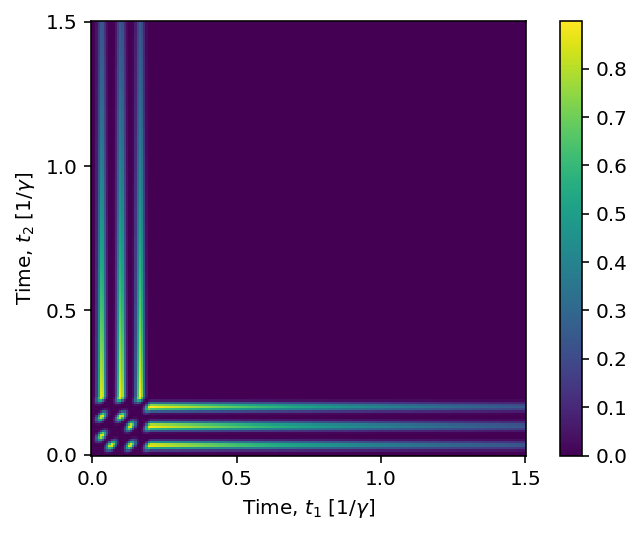

In [6]:
T = 200
tlist = np.linspace(0,1.5/gamma,T)
pulse_area = 6*np.pi
pulse_length = 0.2 / gamma
correlations = np.zeros((T, T))

H = Htls_rft(gamma, pulse_length, pulse_area)
scattered_state = temporal_scattered_state(H, psi0, 2, [sm], tlist)

for i in range(T):
    for j in range(T):
        # temporal_scattered_state() computes only using ordered emission times, so to  
        # get the full set of correlations, we need to use ordered temporal basis vector
        [a,b] = sorted([i,j])
        basis_vec = temporal_basis_vector([[a,b]], T)
        correlations[i,j] = np.abs((basis_vec.dag() * scattered_state).full().item())**2

fig, ax1 = plt.subplots(1,1)
cax = ax1.imshow(correlations, interpolation='nearest', origin='lower')
ax1.set_xticks(np.linspace(0,T-1,4))
ax1.set_xticklabels([0.0, 0.5, 1.0, 1.5])
ax1.set_xlabel("Time, $t_1$ [$1/\gamma$]")
ax1.set_yticks(np.linspace(0,T-1,4))
ax1.set_yticklabels([0.0, 0.5, 1.0, 1.5])
ax1.set_ylabel("Time, $t_2$ [$1/\gamma$]")
fig.colorbar(cax)
plt.show()

### Pulse-wise second-order coherence

Experimentally accessing the temporal correlations given by $G^{(2)}$ or photocount distributions $P_m$ can be quite challenging, so typically a quantity called the pulse-wise second-order coherence is used, defined as:

\begin{equation}
g^{(2)}[0] = \frac{\sum_m m(m-1) P_m}{\left( \sum_m m P_m \right)^2} \approx \frac{2 P_2}{(P_1+2P_2)^2}.
\end{equation}

We can easily compute this with `scattering_probability`, obtaining similar results to Figure 5(d) in Fischer, et al.:

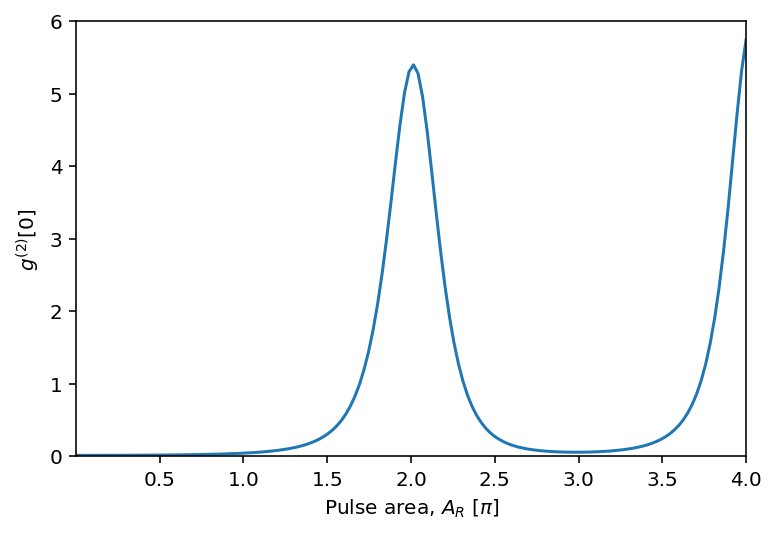

In [7]:
pulse_length = 0.2/gamma
pulse_areas = np.linspace(0.01,4*np.pi,150)
emission_nums = [1,2]
# you can use non-linearly space time bins with scattering_probability()
tlist = np.geomspace(gamma, 21*gamma, 40) - gamma 

def scatter_prob(pulse_area, n):
    # Helper function to allow pool.map parallelism
    return scattering_probability(Htls_rft(gamma, pulse_length, pulse_area), psi0, n, [sm], tlist)

pool = Pool(worker_count)
Pm = dict.fromkeys(emission_nums)
for n in emission_nums:
    args = [(pulse_area, n) for pulse_area in pulse_areas]
    Pm[n] = np.array(pool.starmap(scatter_prob, args))
pool.close()

# Calculate pulse-wise coherence
pulseWiseCoherence = np.sum([m * (m-1) * Pm[m] for m in Pm], axis=0) / \
                     np.square(np.sum([m * Pm[m] for m in Pm], axis=0))

plt.plot(pulse_areas/np.pi, pulseWiseCoherence)
plt.ylim(0,6)
plt.xlim(pulse_areas[0]/np.pi, pulse_areas[-1]/np.pi)
plt.xlabel("Pulse area, $A_R$ $[\pi]$")
plt.ylabel("$g^{(2)}[0]$")
plt.show()

## Multiple waveguides: spontaneous parametric downconversion

We'll now extend the problem to multiple waveguides by simulating the scattering dynamics of spontaneous parametric downconversion. The scattering amplitude discussed above extended to a system with $W$ waveguides is:


\begin{equation}
\left<\hat{\Omega}_{-}^\dagger\right>_{\tilde{\tau}^{(N)}}\equiv\left<\hat{\Omega}_{-}^\dagger\right>_{\vec{\boldsymbol{\tau}}_1^{(m_1)},\vec{\boldsymbol{\tau}}_2^{(m_2)},\dots, \vec{\boldsymbol{\tau}}_M^{(m_M)}} =\bra{\textbf{0}_\text{S}} U_\text{eff}(\tau_\text{max}, \tilde{\tau}_N) \prod_{q=N}^1 \sqrt{\gamma_{Q[q]}}a_{Q[q]} U_\text{eff}(\tilde{\tau}_q,\tilde{\tau}_{q-1}) \ket{\psi_\text{S}(0)}
\end{equation}

as a projection onto $|\vec{\boldsymbol{\tau}}_1^{(m_1)},\vec{\boldsymbol{\tau}}_2^{(m_2)},\dots, \vec{\boldsymbol{\tau}}_W^{(m_W)}\rangle$, where $N = m_1+m_2+ \cdots+ m_W$ is the total number of photons scattered, $\tilde{\tau}^{(N)}$ is a chronologically sorted set of all time indices from the $\vec{\boldsymbol{\tau}}_i^{(m_i)}$'s, and $Q[q]$ is the index of the waveguide corresponding to the photon scattered at $\tilde{\tau}_q$. We present this equation without derivation; see Fischer, et al. for more details.

Consider a SPDC cavity with a Hamiltonian given by a sum of time-independent and -dependent parts $H=H_{0S}+H_{1S}$, with:

$$H_{0S} = \omega_1 a_1^\dagger a_1 + \omega_2 a_2^\dagger a_2,$$ 

and 

$$H_{1S} = g(t) \left(e^{i\omega_p t} a_1 a_2 + e^{-i\omega_p t} a_1^\dagger a_2^\dagger \right),$$

where $a_1$ and $a_2$ annihilate photons at frequencies $\omega_1$ and $\omega_2$, respectively, $\omega_p = \omega_1 + \omega_2$, and $g(t)$ is a function depending on the amplitude of the pump beam and the nonlinear susceptibility of the cavity. As a specific example, let's consider driving the system with a Gaussian pulse, such that $g(t) = g_0 \exp \left( -\frac{(t-t_0)^2}{2\tau^2} \right)$. Truncating the cavity excitation capacity to $n=6$, we define the Hamiltonian for the system, again using a rotating frame transformation as before:

$$H_\text{SPDC} = \left(a_1^\dagger a_2^\dagger + a_1 a_2\right) g(t) + H_\text{eff}\text{ terms},$$ 

where we allow the scattering functions to construct the effective Hamiltonian by adding the $-\frac{i}{2} \sum_n \tt{\text{c_ops}}[n]$ terms.

In [8]:
Ncav = 6                                            # truncated cavity excitation capacity
a1 = tensor(destroy(Ncav), qeye(Ncav))              # left cavity annihilator
a2 = tensor(qeye(Ncav), destroy(Ncav))              # right cavity annihilator
cavity_vac = tensor(basis(Ncav, 0), basis(Ncav, 0)) # vacuum state, 0 excitations in either cavity
w1 = w2 = 1/gamma                                   # cavity frequencies
wp = w1 + w2                                        # pump frequency
spdc_c_ops = [np.sqrt(gamma)*a1, np.sqrt(gamma)*a2] # cavity collapse operators

# Gaussian laser pulse
def g(t, t0, g0, tau):
    return g0 * np.exp(-1 * (t-t0)**2 / (2 * tau**2))

# SPDC Hamiltonian with rotating frame transformation applied
def Hspdc(t0, g0, tau):  
    return [[a1.dag() * a2.dag() + a1 * a2, lambda t, args: g(t, t0, g0, tau)]]

### Two-photon scattering amplitudes

Here we compute the amplitude for the two-photon part of the output state projected onto the temporal basis. We plot only the case where one photon is scattered into the first waveguide and the other into the second: this is of course symmetric under reversal, and the cases of two photons scattered into only one waveguide are forbidden and have amplitude 0, since the difference in the number of photons in the two cavities is conserved in the presence of the pump beam. 

Using similar parameters as Fig 6(a) in Fischer, et al., we obtain a similar result:

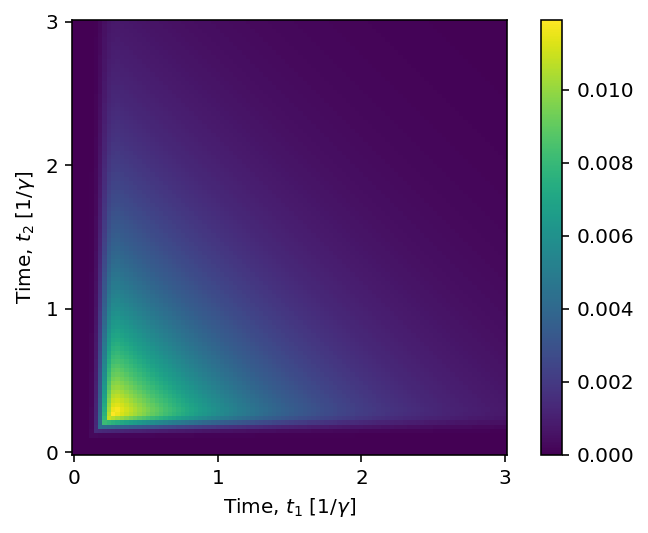

In [9]:
tau = 0.05 / gamma  # width of gaussian pulse
t0 = 3.5 * tau      # center of gaussian pulse
g0 = gamma          # amplitude of gaussian pulse
T = 100             # number of time bins
W = 2               # number of waveguides

tlist = np.linspace(0, 3/gamma, T)
phi = temporal_scattered_state(Hspdc(t0, g0, tau), cavity_vac, 2, spdc_c_ops, tlist)
amplitudes = np.zeros((W, W, T, T,))

for i, tau1 in enumerate(tlist):
    for j, tau2 in enumerate(tlist):
        [a,b] = sorted([i,j]) # sort the indices to comply with time-ordering
        for wg1 in [0,1]:
            for wg2 in [0,1]:
                indices = [[] for _ in range(W)]
                indices[wg1].append(a)
                indices[wg2].append(b) 
                basisVec = temporal_basis_vector(indices, T)
                amplitudes[wg1,wg2,i,j] = np.abs((basisVec.dag() * phi).full().item())**2
                
# Plot the correlation for emission times emitted into different waveguides; note
# that amplitudes[0][0] = amplitudes[1][1] = 0 and amplitudes[0][1] = amplitudes[1][0].
fig, ax1 = plt.subplots(1,1)
cax = ax1.imshow(amplitudes[0][1], interpolation='nearest', origin='lower')
ax1.set_xticks(np.linspace(0,T-1,4))
ax1.set_xticklabels([0, 1, 2, 3])
ax1.set_xlabel("Time, $t_1$ [$1/\gamma$]")
ax1.set_yticks(np.linspace(0,T-1,4))
ax1.set_yticklabels([0, 1, 2, 3])
ax1.set_ylabel("Time, $t_2$ [$1/\gamma$]")
fig.colorbar(cax)
plt.show()

### Multi-waveguide photon emission probability

Finally, we can compute the variation in probability of single-and two-photon emission as a function of the pulse length. This simulation exhibits a slight variation from the expected behavior in Figure 5(c) of Fischer, et al., more apparent at larger times, due to the interaction timescale of interest increasing relative to the total timescale as a function of pulse length. However, the results do closely resemble the expected analytical results:

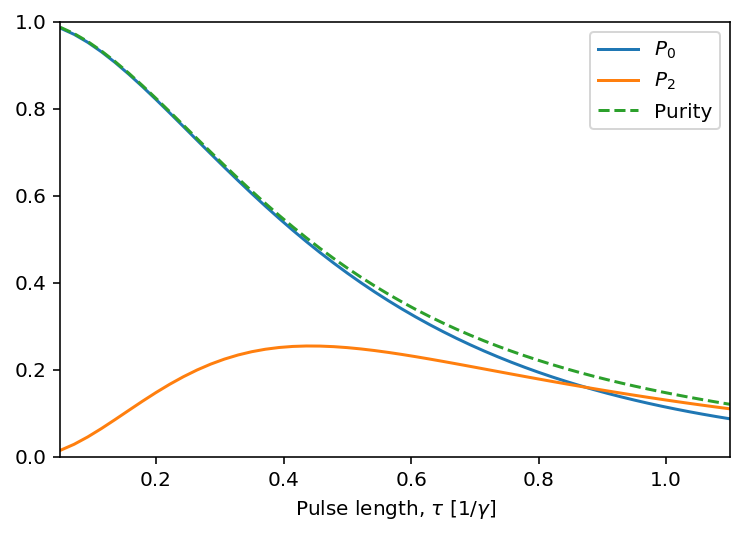

In [10]:
emission_nums = [0, 2]
pulse_lengths = np.linspace(0.05/gamma, 1.1 / gamma, 50)
tlist = np.geomspace(1/gamma, 21/gamma, 50) - 1/gamma

def scattering_probability_multiprocess(pulse_length, n):
    tau = pulse_length
    t0 = 3.5 * tau
    H = Hspdc(t0, gamma, tau)
    return scattering_probability(H, cavity_vac, n, spdc_c_ops, tlist)

pool = Pool(worker_count)
probs = {}
for n in emission_nums:
    args = [(pulse_length, n) for pulse_length in pulse_lengths]
    probs[n] = np.array(pool.starmap(scattering_probability_multiprocess, args))
pool.close()

# Compute the purity of the output state
purity = [probs[2][p] / (1-probs[0][p]) for p in range(len(pulse_lengths))]

# Plot it
for n in probs:
    plt.plot(pulse_lengths / gamma, probs[n], label = "$P_{}$".format(n))
plt.plot(pulse_lengths / gamma, purity, '--', label = "Purity")
plt.ylim(0,1)
plt.xlim(pulse_lengths[0]/gamma, pulse_lengths[-1]/gamma)
plt.xlabel("Pulse length, $\\tau$ $[1/\gamma]$")
plt.legend()
plt.show()

### Software version:

In [11]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.3.0.dev0+7a7236e1
Numpy,1.13.3
SciPy,0.19.1
matplotlib,2.1.0
Cython,0.26.1
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,6.2.1
Python,"3.6.3 |Anaconda custom (64-bit)| (default, Oct 6 2017, 12:04:38) [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]"
OS,posix [darwin]
